In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2 # OpenCV for image processing

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

# 設定設備 (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [9]:
# --- 設定資料路徑 ---
BASE_DIR = "Dataset/" # 請依照你的資料夾路徑修改
TRAIN_IMAGE_DIR = os.path.join(BASE_DIR, "Train/Image/")
TRAIN_MASK_DIR = os.path.join(BASE_DIR, "Train/Mask/")
TEST_IMAGE_DIR = os.path.join(BASE_DIR, "Test/Image/") # 測試集影像資料夾

# --- 基本參數 ---
IMAGE_HEIGHT = 128  # 影像高度 (可調整)
IMAGE_WIDTH = 128   # 影像寬度 (可調整)
BATCH_SIZE = 16     # 批次大小 (可調整)
EPOCHS = 25         # 訓練週期 (可調整)
LEARNING_RATE = 1e-4 # 學習率 (可調整)
VAL_SPLIT = 0.2     # 驗證集比例


In [24]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_ids, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_ids = image_ids
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx] # 例如 "00001.jpg"
        
        # 載入影像
        img_path = os.path.join(self.image_dir, img_id)
        image_pil = Image.open(img_path).convert("L") # 轉換為灰階

        # 應用影像轉換
        if self.transform:
            image_tensor = self.transform(image_pil)
        else:
            # 備用：如果沒有提供 transform，至少轉換為 Tensor
            image_tensor = transforms.ToTensor()(image_pil)

        # 處理遮罩
        if self.mask_dir: # 訓練或驗證集
            mask_filename = img_id.replace('.jpg', '.png') # 假設遮罩檔名對應
            mask_path = os.path.join(self.mask_dir, mask_filename)
            mask_pil = Image.open(mask_path).convert("L")

            if self.mask_transform:
                mask_tensor = self.mask_transform(mask_pil) # 應用遮罩轉換 (包含 ToTensor)
                mask_tensor = (mask_tensor > 0.5).float() # 確保二值化為 0.0 或 1.0
            else:
                # 備用：如果訓練/驗證集沒有 mask_transform，至少轉換並二值化
                mask_tensor = transforms.ToTensor()(mask_pil)
                mask_tensor = (mask_tensor > 0.5).float()
        else: # 測試集 (self.mask_dir is None)
            # 創建一個 dummy mask 張量。
            # DataLoader 需要一個張量，即使我們在預測時不使用這個遮罩的標籤。
            # 形狀應為 [1, IMAGE_HEIGHT, IMAGE_WIDTH] (單通道)
            # dtype=torch.float32 以匹配模型和損失函數的期望 (儘管測試時不計算損失)
            mask_tensor = torch.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH), dtype=torch.float32)

        return image_tensor, mask_tensor


In [4]:
# 影像的轉換
image_transform = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.ToTensor(), # 將 PIL Image 或 numpy.ndarray 轉換為 torch.Tensor，並將像素值縮放到 [0.0, 1.0]
    # transforms.Normalize(mean=[0.5], std=[0.5]) # 可選的標準化 (灰階影像)
])

# 遮罩的轉換
mask_transform = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=transforms.InterpolationMode.NEAREST), # 對遮罩使用最近鄰插值
    transforms.ToTensor() # 將 PIL Image 或 numpy.ndarray 轉換為 torch.Tensor
])


In [23]:
# 獲取所有訓練影像的 ID (不含副檔名)
all_train_image_files = [f for f in os.listdir(TRAIN_IMAGE_DIR) if f.endswith('.jpg')]
train_ids = [os.path.splitext(f)[0] for f in all_train_image_files] # 取檔名 (不含 .jpg)

# 切分訓練集和驗證集
# 注意：這裡我們傳遞的是不帶副檔名的 ID，Dataset 內部會處理 .jpg 和 .png
train_img_ids, val_img_ids = train_test_split(all_train_image_files, test_size=VAL_SPLIT, random_state=42)

print(f"Total training images: {len(all_train_image_files)}")
print(f"Number of training images: {len(train_img_ids)}")
print(f"Number of validation images: {len(val_img_ids)}")

# 建立訓練資料集和資料載入器
train_dataset = SegmentationDataset(
    image_dir=TRAIN_IMAGE_DIR,
    mask_dir=TRAIN_MASK_DIR,
    image_ids=train_img_ids, # 傳遞帶 .jpg 的檔名
    transform=image_transform,
    mask_transform=mask_transform
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()//2) # 使用一半的CPU核心

# 建立驗證資料集和資料載入器
val_dataset = SegmentationDataset(
    image_dir=TRAIN_IMAGE_DIR,
    mask_dir=TRAIN_MASK_DIR,
    image_ids=val_img_ids, # 傳遞帶 .jpg 的檔名
    transform=image_transform,
    mask_transform=mask_transform
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()//2)

# 檢查一個批次的資料形狀
images, masks = next(iter(train_loader))
print(f"Sample batch - Images shape: {images.shape}, Masks shape: {masks.shape}")
print(f"Sample batch - Images dtype: {images.dtype}, Masks dtype: {masks.dtype}")
print(f"Sample batch - Images min/max: {images.min()}/{images.max()}")
print(f"Sample batch - Masks min/max: {masks.min()}/{masks.max()}") # 應該是 0.0 和 1.0

Total training images: 1087
Number of training images: 869
Number of validation images: 218
Sample batch - Images shape: torch.Size([16, 1, 128, 128]), Masks shape: torch.Size([16, 1, 128, 128])
Sample batch - Images dtype: torch.float32, Masks dtype: torch.float32
Sample batch - Images min/max: 0.003921568859368563/0.9490196108818054
Sample batch - Masks min/max: 0.0/1.0


In [11]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# 初始化模型
# 輸入是灰階影像，所以 n_channels=1
# 輸出是單一遮罩，所以 n_classes=1 (代表前景的機率)
model = UNet(n_channels=1, n_classes=1).to(device)

# 測試模型是否能處理輸入
dummy_input = torch.randn(1, 1, IMAGE_HEIGHT, IMAGE_WIDTH).to(device) # (batch_size, channels, height, width)
output = model(dummy_input)
print(f"Model output shape: {output.shape}") # 應該是 (1, 1, IMAGE_HEIGHT, IMAGE_WIDTH)

Model output shape: torch.Size([1, 1, 128, 128])


In [12]:
# 損失函數
# BCEWithLogitsLoss 結合了 Sigmoid 層和 BCELoss，數值上更穩定
criterion = nn.BCEWithLogitsLoss()

# 優化器
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# (可選) 學習率調度器
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1, verbose=True)


In [13]:
def dice_coefficient(preds, targets, smooth=1e-6):
    """計算 Dice Coefficient"""
    # preds: 模型的預測 (經過 sigmoid 和閾值處理)
    # targets: 真實的遮罩
    # smooth: 防止分母為零的小常數

    preds = torch.sigmoid(preds) # 先應用 sigmoid 轉換為機率
    preds = (preds > 0.5).float() # 應用閾值轉換為二元遮罩 (0 或 1)
    
    intersection = (preds * targets).sum(dim=(2, 3)) # 計算交集 (在 H 和 W 維度上求和)
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) # 計算聯集
    
    dice = (2. * intersection + smooth) / (union + smooth) # 計算 Dice
    
    return dice.mean() # 回傳批次的平均 Dice


In [14]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train() # 設定模型為訓練模式
    epoch_loss = 0.0
    epoch_dice = 0.0
    
    for i, (images, masks) in enumerate(loader):
        images = images.to(device)
        masks = masks.to(device) # masks 應該是 [N, 1, H, W] 且值為 0 或 1
        
        optimizer.zero_grad() # 清除梯度
        outputs = model(images) # 前向傳播
        
        loss = criterion(outputs, masks) # 計算損失
        
        loss.backward() # 反向傳播
        optimizer.step() # 更新權重
        
        epoch_loss += loss.item()
        # 計算 Dice (用於監控，注意這裡的 outputs 是 logits)
        dice = dice_coefficient(outputs.detach(), masks.detach()) # detach() 避免追蹤梯度
        epoch_dice += dice.item()

        if (i + 1) % 50 == 0: # 每 50 個 batch 印一次訊息
             print(f"  Batch {i+1}/{len(loader)}, Train Loss: {loss.item():.4f}, Train Dice: {dice.item():.4f}")
        
    return epoch_loss / len(loader), epoch_dice / len(loader)

def validate_one_epoch(model, loader, criterion, device):
    model.eval() # 設定模型為評估模式
    epoch_loss = 0.0
    epoch_dice = 0.0
    
    with torch.no_grad(): # 在評估模式下，不需要計算梯度
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            epoch_loss += loss.item()
            dice = dice_coefficient(outputs, masks) # 這裡的 outputs 也是 logits
            epoch_dice += dice.item()
            
    return epoch_loss / len(loader), epoch_dice / len(loader)

# --- 開始訓練 ---
best_val_dice = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_dice': [], 'val_dice': []}

print("Starting Training...")
for epoch in range(EPOCHS):
    print(f"--- Epoch {epoch+1}/{EPOCHS} ---")
    
    train_loss, train_dice = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_dice = validate_one_epoch(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)
    
    print(f"Epoch {epoch+1} Summary: ")
    print(f"  Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}")
    print(f"  Val Loss: {val_loss:.4f},   Val Dice: {val_dice:.4f}")
    
    # 如果使用學習率調度器
    # if scheduler:
    #     scheduler.step(val_loss) # 或者 scheduler.step(val_dice) 如果監控 dice

    # 儲存最佳模型 (基於驗證集 Dice)
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(model.state_dict(), 'best_model_segmentation.pth')
        print(f"  New best model saved with Val Dice: {best_val_dice:.4f}")

print("Training Finished!")
print(f"Best Validation Dice: {best_val_dice:.4f}")


Starting Training...
--- Epoch 1/25 ---
  Batch 50/55, Train Loss: 0.3029, Train Dice: 0.8270
Epoch 1 Summary: 
  Train Loss: 0.3695, Train Dice: 0.7699
  Val Loss: 0.3848,   Val Dice: 0.7809
  New best model saved with Val Dice: 0.7809
--- Epoch 2/25 ---
  Batch 50/55, Train Loss: 0.2889, Train Dice: 0.8701
Epoch 2 Summary: 
  Train Loss: 0.2896, Train Dice: 0.8251
  Val Loss: 0.2679,   Val Dice: 0.7995
  New best model saved with Val Dice: 0.7995
--- Epoch 3/25 ---
  Batch 50/55, Train Loss: 0.2368, Train Dice: 0.8366
Epoch 3 Summary: 
  Train Loss: 0.2647, Train Dice: 0.8390
  Val Loss: 0.2519,   Val Dice: 0.8703
  New best model saved with Val Dice: 0.8703
--- Epoch 4/25 ---
  Batch 50/55, Train Loss: 0.2304, Train Dice: 0.8230
Epoch 4 Summary: 
  Train Loss: 0.2387, Train Dice: 0.8528
  Val Loss: 0.2386,   Val Dice: 0.8503
--- Epoch 5/25 ---
  Batch 50/55, Train Loss: 0.2385, Train Dice: 0.8687
Epoch 5 Summary: 
  Train Loss: 0.2256, Train Dice: 0.8634
  Val Loss: 0.2461,   Val Di

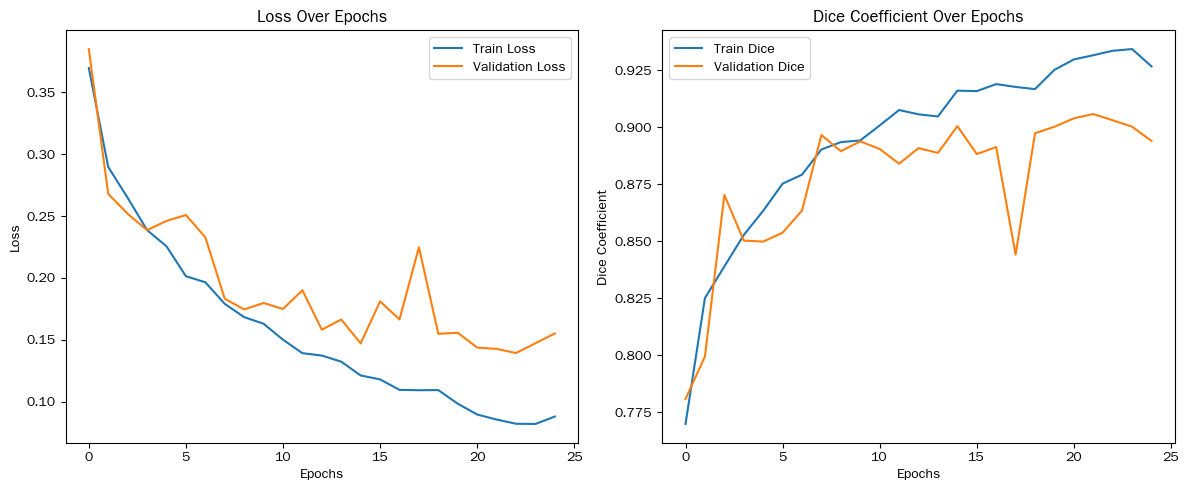

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_dice'], label='Train Dice')
plt.plot(history['val_dice'], label='Validation Dice')
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
def mask_to_rle(mask):
    """
    將二元遮罩轉換為 RLE 編碼。
    mask: numpy array, 1 - mask, 0 - background
    返回 RLE 編碼的字串
    """
    pixels = mask.flatten() # 直接使用 flatten() 即可，不需要 T
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(map(str, runs))


In [28]:
# 載入最佳模型
model.load_state_dict(torch.load('best_model_segmentation.pth', map_location=device))
model.eval() # 設定為評估模式

# 準備測試資料集
test_image_files = [f for f in os.listdir(TEST_IMAGE_DIR) if f.endswith('.jpg')]
# 對測試檔案排序，以確保提交順序與 ID 一致 (如果 ID 是基於檔名排序的話)
test_image_files.sort()

test_ids = [os.path.splitext(f)[0] for f in test_image_files]

# 測試集 Dataset (沒有 mask_dir)
test_dataset = SegmentationDataset(
    image_dir=TEST_IMAGE_DIR,
    mask_dir=None, # 測試集沒有遮罩
    image_ids=test_image_files, # 傳遞帶 .jpg 的檔名
    transform=image_transform, # 使用與訓練時相同的影像轉換
    mask_transform=None #不需要遮罩轉換
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()//2)


submission_ids = []
submission_rles = []

print("Generating predictions for test set...")
with torch.no_grad():
    current_idx = 0
    for images, _ in test_loader: # _ 代表 dummy masks
        images = images.to(device)
        outputs = model(images) # 輸出是 [batch_size, 1, H, W] 的 logits

        # 將 logits 轉換為機率，然後轉換為二元遮罩
        probs = torch.sigmoid(outputs) # [batch_size, 1, H, W]
        pred_masks = (probs > 0.5).cpu().numpy().astype(np.uint8) # [batch_size, 1, H, W], 轉換到 CPU 並轉為 numpy

        # 對每個預測的遮罩進行 RLE 編碼
        for i in range(pred_masks.shape[0]):
            single_mask = pred_masks[i, 0, :, :] # 取出單個遮罩 [H, W]
            
            # 重要: RLE 編碼前，遮罩需要是原始影像的尺寸
            # 如果模型輸出的尺寸與原始影像不同，需要將 single_mask resize 回原始尺寸
            # 這裡我們假設模型輸出的 IMAGE_HEIGHT, IMAGE_WIDTH 就是提交 RLE 所需的尺寸
            # 如果不是，你需要先讀取原始影像的尺寸，然後 resize single_mask
            # 例如:
            original_img_path = os.path.join(TEST_IMAGE_DIR, test_image_files[current_idx])
            original_pil_img = Image.open(original_img_path)
            original_width, original_height = original_pil_img.size
            single_mask_resized = cv2.resize(single_mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)
            rle = mask_to_rle(single_mask_resized)

            submission_ids.append(test_ids[current_idx]) # 使用預先排序的 test_ids
            submission_rles.append(rle)
            current_idx += 1

# 創建提交 DataFrame
submission_df = pd.DataFrame({'ID': submission_ids, 'Mask': submission_rles})

# 產生提交 CSV 檔案
submission_df.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully.")
print(submission_df.head())


Generating predictions for test set...
Submission file 'submission.csv' created successfully.
        ID                                               Mask
0  0001087  92601 40 93625 40 94649 40 95673 40 96697 40 9...
1  0001088  166281 72 167305 72 168329 72 169353 72 170377...
2  0001089  74305 32 75329 32 76353 32 77377 32 78401 32 7...
3  0001090  276881 56 277905 56 278929 56 279953 56 280977...
4  0001091  209425 16 210449 16 211473 16 212497 16 213521...


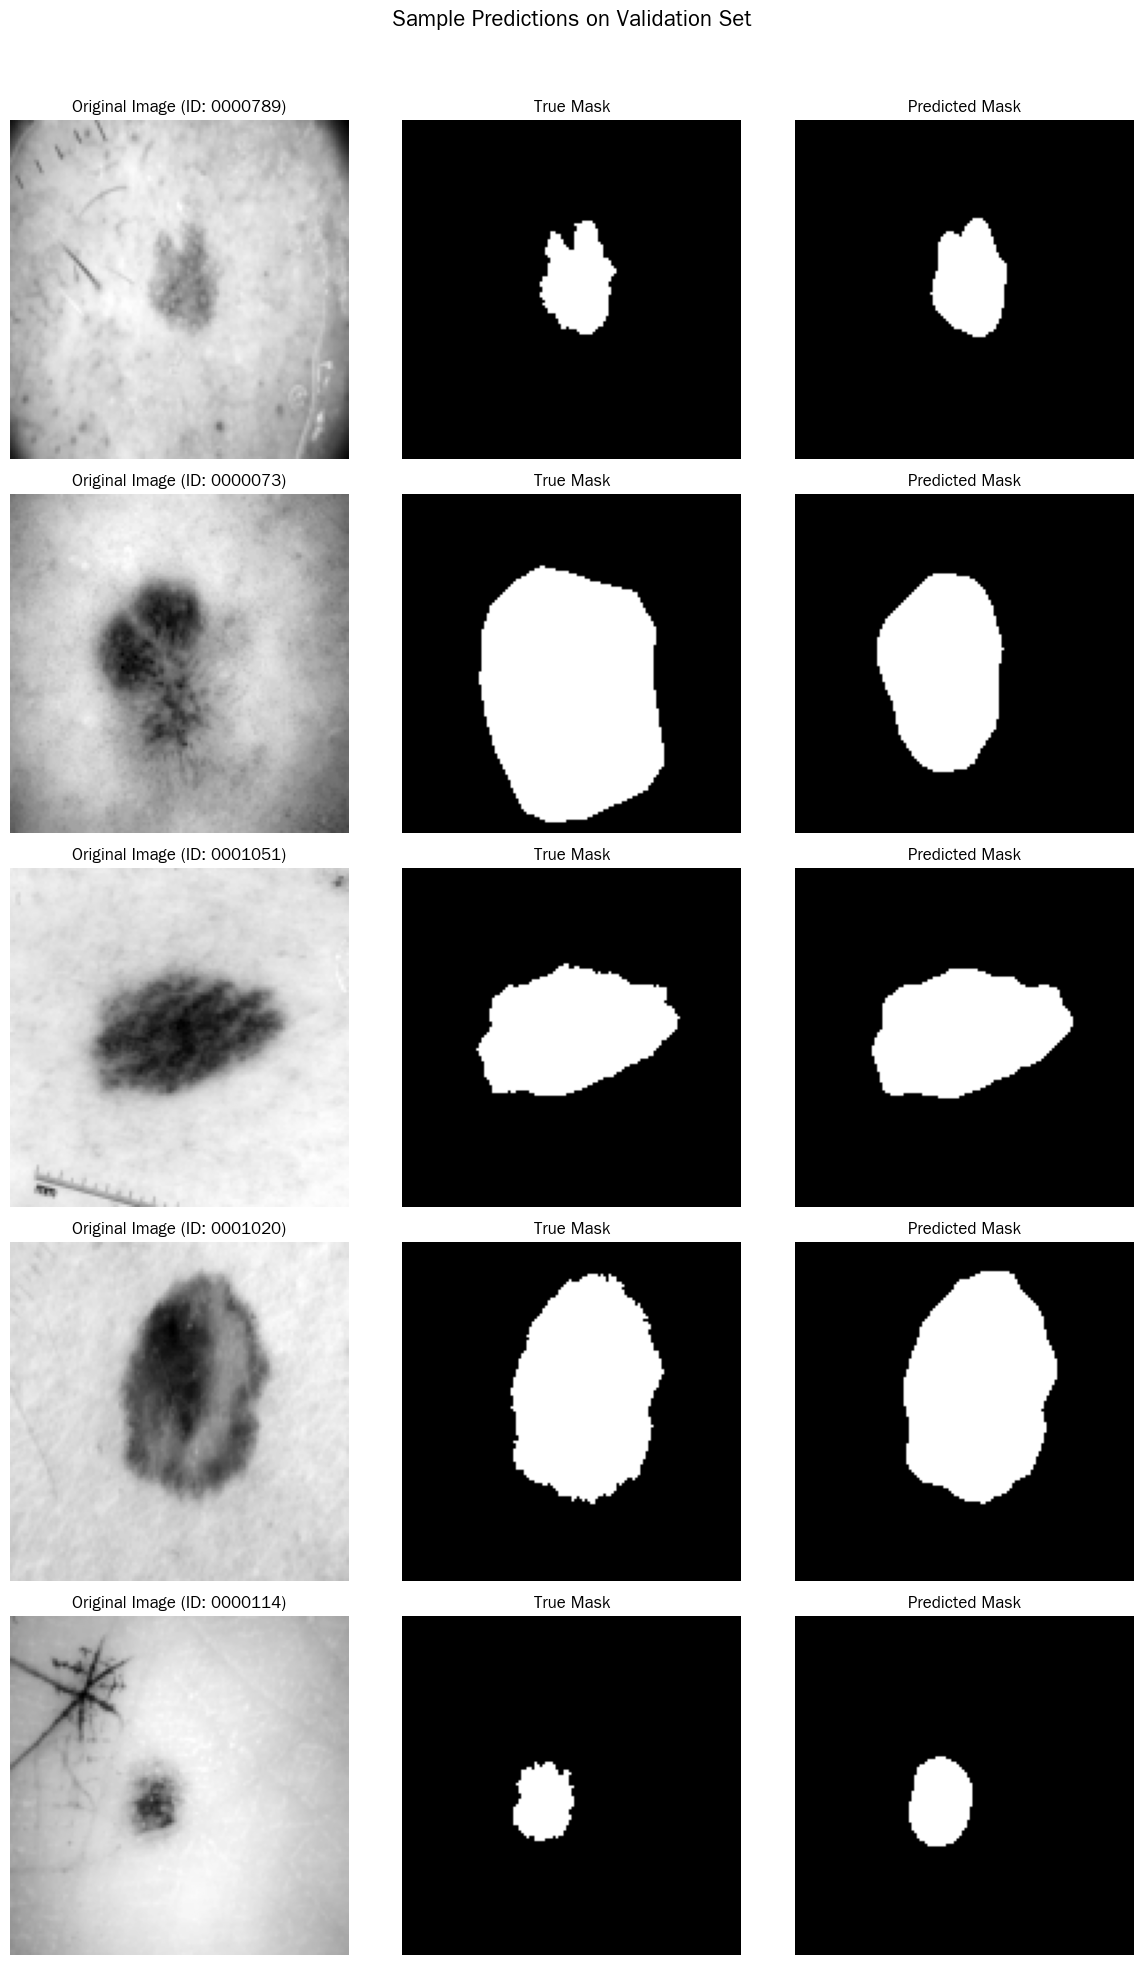

In [29]:
# 載入最佳模型 (如果尚未載入)
# model.load_state_dict(torch.load('best_model_segmentation.pth', map_location=device))
# model.eval()

# 隨機選取幾張驗證集影像進行視覺化
num_samples_to_show = 5
indices = np.random.choice(len(val_dataset), num_samples_to_show, replace=False)

fig, axes = plt.subplots(num_samples_to_show, 3, figsize=(12, num_samples_to_show * 4))
fig.suptitle("Sample Predictions on Validation Set", fontsize=16)


for i, idx in enumerate(indices):
    image, true_mask = val_dataset[idx] # 獲取單個樣本
    
    image_for_plot = image.squeeze().cpu().numpy() # (H, W)
    true_mask_for_plot = true_mask.squeeze().cpu().numpy() # (H, W)
    
    # 獲取模型預測
    with torch.no_grad():
        input_tensor = image.unsqueeze(0).to(device) # (1, 1, H, W)
        output_tensor = model(input_tensor) # (1, 1, H, W) logits
        pred_prob = torch.sigmoid(output_tensor) # (1, 1, H, W) probabilities
        pred_mask = (pred_prob > 0.5).squeeze().cpu().numpy().astype(np.uint8) # (H, W)
        
    # 繪製原圖
    if num_samples_to_show == 1:
        ax_img, ax_true, ax_pred = axes[0], axes[1], axes[2]
    else:
        ax_img, ax_true, ax_pred = axes[i, 0], axes[i, 1], axes[i, 2]

    ax_img.imshow(image_for_plot, cmap='gray')
    ax_img.set_title(f"Original Image (ID: {val_dataset.image_ids[idx].split('.')[0]})")
    ax_img.axis('off')
    
    # 繪製真實遮罩
    ax_true.imshow(true_mask_for_plot, cmap='gray')
    ax_true.set_title("True Mask")
    ax_true.axis('off')
    
    # 繪製預測遮罩
    ax_pred.imshow(pred_mask, cmap='gray')
    ax_pred.set_title("Predicted Mask")
    ax_pred.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # 調整佈局以容納 suptitle
plt.show()
